In [28]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
import numpy as np
import missingno

from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, fbeta_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from category_encoders import BinaryEncoder

import tensorflow
from tensorflow.keras import optimizers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dropout, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

In [29]:
df = pd.read_csv("train_data.csv")
timestep = 17 #from 1 to 23 (17 with the current NaN strategy)
threshold_for_classification = -30
fill_X = -0.25
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
seed = 11

#RNN hiperparameter
epochs = 50
batch = 64
val_split = 0.25
test_split = 0.25
lr = 0.0001
adam = optimizers.Nadam(learning_rate=0.001) #(lr)
class_weight = {True:  1.,
                False: 1.}
verbose = 1

In [30]:
#Dropping first the empty column and then rows with NaNs
df = df.drop("c_rcs_estimate", axis=1)
df = df.dropna(how='any')

#Filtering events with len=1 or min_tca > 2 or max_tca < 2
def conditions(event):
    x = event["time_to_tca"].values
    return ((x.min()<2.0) & (x.max()>2.0) & (x.shape[0]>1))
df = df.groupby('event_id').filter(conditions)

#OHE for c_object_type (5 categories) -> 5 new features
df["mission_id"] = df["mission_id"].astype('category')
df["c_object_type"] = df["c_object_type"].astype('category')
df = pd.get_dummies(df)

#Getting y as 1D-array
y = df.groupby(["event_id"])["risk"].apply(lambda x: x.iloc[-1]).values.reshape(-1, 1)

#Scaling y
_ = y_scaler.fit(df["risk"].values.reshape(-1, 1)) #using the whole risk feature to scale the target 'y'
y = y_scaler.transform(y)

#Getting X as df (dropping rows with tca < 2) 
df = df.loc[df["time_to_tca"]>2]

#Adding feature 'event_length' for counting how many instances each event has
df["event_length"] = df.groupby('event_id')['event_id'].transform('value_counts')

#Scaling X
df = pd.DataFrame(X_scaler.fit_transform(df), columns=df.columns)

#Transforming X into a 3D-array
events = df["event_id"].nunique() #rows
features = len(df.columns) #columns

X = np.zeros((events,timestep,features))
X.fill(fill_X)

i = 0
def df_to_3darray(event):
    global X, i
    #Transforming an event to time series (1,timesteps, columns)
    row = event.values.reshape(1,event.shape[0],event.shape[1])
    #Condition is needed to slice arrays correctly
    #Condition -> is timestep greater than the event's time series length? 
    if(timestep>=row.shape[1]):
        X[i:i+1,-row.shape[1]:,:] = row
    else:
        X[i:i+1,:,:] = row[:,-timestep:,:]
    #index to iterate over X array
    i = i + 1
    #dataframe remains intact, while X array has been filled.
    return event

df.groupby("event_id").apply(df_to_3darray)

#Dropping event_id to remove noise
X = X[:,:,1:]

#TODO: Padding with specific values column-wise instead of zeros.
#TODO: Separating time dependent and independent feature in 2 X arrays

print(X.shape, y.shape)

(7311, 17, 124) (7311, 1)


In [31]:
#computing scaled threshold 
th = np.array([threshold_for_classification]).reshape(-1,1)
th = y_scaler.transform(th)
threshold_scaled = th[0,0]

#Splitting arrays
y_boolean = (y > threshold_scaled).reshape(-1,1)
X_train, X_test, y_train_numeric, y_test_numeric = train_test_split(X, y, 
                                                    stratify=y_boolean, 
                                                    shuffle=True,
                                                    random_state=seed,
                                                    test_size = test_split
                                                  )

y_train_boolean = (y_train_numeric > threshold_scaled).reshape(-1,1)
X_train, X_val, y_train_numeric, y_val_numeric = train_test_split(X_train, y_train_numeric, 
                                                    stratify=y_train_boolean, 
                                                    shuffle=True,
                                                    random_state=seed,
                                                    test_size = val_split
                                                  )
#transforming it into a classification task -> y_train, y_test boolean
y_train = (y_train_numeric > threshold_scaled).reshape(-1,1)
y_val = (y_val_numeric > threshold_scaled).reshape(-1,1)
y_test = (y_test_numeric > threshold_scaled).reshape(-1,1)

#Percentage of high risks in train
print("TRAIN {:0.1f}, {:0.1f}, {:0.3f}".format(np.sum(y_train), y_train.shape[0], np.sum(y_train)/y_train.shape[0]))
#Percentage of high risks in val
print("VAL   {:0.1f}, {:0.1f}, {:0.3f}".format(np.sum(y_val), y_val.shape[0], np.sum(y_val)/y_val.shape[0]))
#Percentage of high risks in test
print("TEST  {:0.1f}, {:0.1f}, {:0.3f}".format(np.sum(y_test), y_test.shape[0], np.sum(y_test)/y_test.shape[0]))

TRAIN 799.0, 4112.0, 0.194
VAL   267.0, 1371.0, 0.195
TEST  356.0, 1828.0, 0.195


In [32]:
# Model
model = Sequential()

model.add(Input(batch_shape=(batch, X_train.shape[1], X_train.shape[2])))
model.add(Conv1D(10, 3, activation='relu'))
model.add(Conv1D(10, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (64, 15, 10)              3730      
_________________________________________________________________
conv1d_16 (Conv1D)           (64, 13, 10)              310       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (64, 6, 10)               0         
_________________________________________________________________
dropout_6 (Dropout)          (64, 6, 10)               0         
_________________________________________________________________
flatten_4 (Flatten)          (64, 60)                  0         
_________________________________________________________________
dense_8 (Dense)              (64, 8)                   488       
_________________________________________________________________
dense_9 (Dense)              (64, 1)                  

In [33]:
model_history = model.fit(X_train, y_train, 
                          epochs=epochs, 
                          batch_size=batch, 
                          shuffle=True, 
                          validation_data=(X_val, y_val),
                          verbose=verbose,
                          class_weight=class_weight
                         ).history

Train on 4112 samples, validate on 1371 samples
Epoch 1/50
4112/4112 [==============================] - 1s 253us/sample - loss: 0.5094 - accuracy: 0.7857 - val_loss: 0.4545 - val_accuracy: 0.8053
Epoch 2/50
4112/4112 [==============================] - 0s 56us/sample - loss: 0.4545 - accuracy: 0.8050 - val_loss: 0.4677 - val_accuracy: 0.8053
Epoch 3/50
4112/4112 [==============================] - 0s 56us/sample - loss: 0.4328 - accuracy: 0.8054 - val_loss: 0.4210 - val_accuracy: 0.8053
Epoch 4/50
4112/4112 [==============================] - 0s 57us/sample - loss: 0.4259 - accuracy: 0.8062 - val_loss: 0.4214 - val_accuracy: 0.8053
Epoch 5/50
4112/4112 [==============================] - 0s 60us/sample - loss: 0.4147 - accuracy: 0.8050 - val_loss: 0.4007 - val_accuracy: 0.8053
Epoch 6/50
4112/4112 [==============================] - 0s 57us/sample - loss: 0.4026 - accuracy: 0.8050 - val_loss: 0.4004 - val_accuracy: 0.8053
Epoch 7/50
4112/4112 [==============================] - 0s 69us/sampl

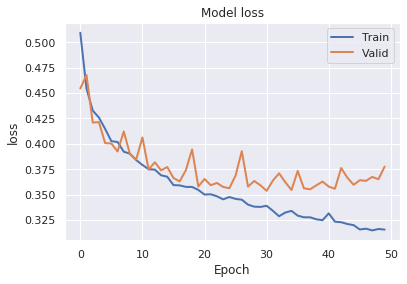

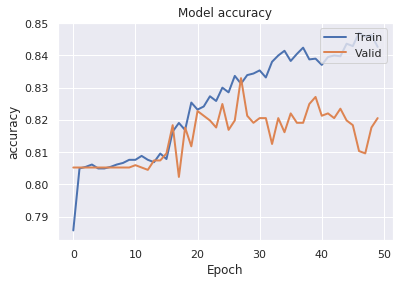

In [34]:
sns.set()

for graph in ['loss', 'accuracy']:
    
    plt.plot(model_history[graph], linewidth=2, label='Train')
    plt.plot(model_history['val_'+graph], linewidth=2, label='Valid')
    
    plt.legend(loc='upper right')
    plt.title('Model '+graph)
    plt.ylabel(graph)
    plt.xlabel('Epoch')
    
    plt.show()

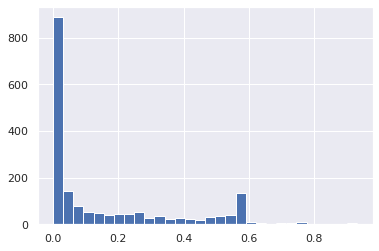

LSTM model: 4.616, 0.622, 0.135


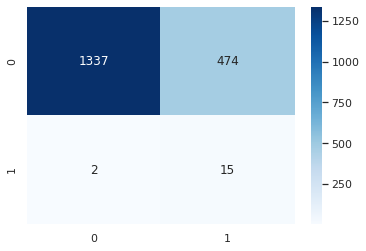

Constant prediction: 13.123, 0.588, 0.045


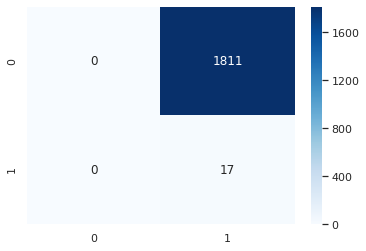

Predicting last value: 1.318, 0.571, 0.433


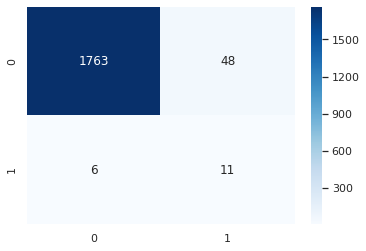

In [35]:
#Model Evaluation
high_risk_real_value = -5.0
low_risk_real_value  = -6.0001
classification_threshold = 0.25

def evaluate(name, y_pred):
    
    #rescaling data
    y_test_scaled = y_scaler.inverse_transform(y_test_numeric)
    
    #getting numeric predictions from boolean predictions
    y_pred_numeric = np.zeros((y_pred.shape[0],y_pred.shape[1]))
    y_pred_numeric[y_pred==True] = high_risk_real_value
    y_pred_numeric[y_pred==False] = low_risk_real_value
    
    #getting predictions greater than -6.0 in real data (y_test_scaled)
    y_pred_mse = y_pred_numeric[np.where(y_test_scaled >= -6.0)]
    y_test_mse = y_test_scaled[np.where(y_test_scaled >= -6.0)]
    
    mse = mean_squared_error(y_test_mse, y_pred_mse)
    
    y_real_bool = (y_test_scaled >= -6.0).reshape(-1,1)
    
    f_beta = fbeta_score(y_real_bool, y_pred, 2)
    score = mse / f_beta
    print(name, "{:0.3f}, {:0.3f}, {:0.3f}".format(score, mse, f_beta))
        
    hm = sns.heatmap(confusion_matrix(y_real_bool, y_pred), annot=True, cmap="Blues", fmt='d')# font size
    bottom, top = hm.get_ylim()
    hm.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()

#Predicting with model
y_model = model.predict(X_test, batch_size=batch)
plt.hist(y_model, bins=30)
plt.show()
y_model = (y_model > classification_threshold).reshape(-1,1)
evaluate("LSTM model:", y_model)

#Predicting -5 always
y_constant = np.ones((y_test.shape[0],y_test.shape[1]), dtype=bool)
evaluate("Constant prediction:", y_constant)

#Predicting last value
y_last = X_test[:,-1,1]
tmp = np.array([-6]).reshape(-1,1)
tmp = y_scaler.transform(tmp)
tmp = tmp[0,0]
y_last = (y_last > tmp).reshape(-1,1)
evaluate("Predicting last value:", y_last)

Predicting last value: 17.412, 7.540, 0.433


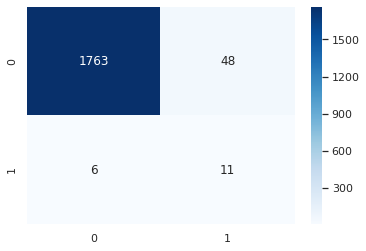

In [36]:
#Predicting last value
def recurrent_evaluate(name, y_pred):
    
    #Scaling both real predicted
    y_pred_scaled = y_scaler.inverse_transform(y_pred)
    y_real_scaled = y_scaler.inverse_transform(y_test_numeric)
    
    #boolean data
    y_pred_bool = (y_pred_scaled >= -6.0).reshape(-1,1)
    y_real_bool = (y_real_scaled >= -6.0).reshape(-1,1)
    f_beta = fbeta_score(y_real_bool, y_pred_bool, 2)
    
    #getting predictions greater than -6.0 in real data (y_real_scaled)
    y_pred_mse = y_pred_scaled[np.where(y_real_scaled >= -6.0)]
    y_real_mse = y_real_scaled[np.where(y_real_scaled >= -6.0)]
    mse = mean_squared_error(y_real_mse, y_pred_mse)
    
    #F-beta score
    score = mse / f_beta
    print(name, "{:0.3f}, {:0.3f}, {:0.3f}".format(score, mse, f_beta))
        
    #Confusion matrix
    hm = sns.heatmap(confusion_matrix(y_real_bool, y_pred_bool), annot=True, cmap="Blues", fmt='d')# font size
    bottom, top = hm.get_ylim()
    hm.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()

    
y_last = X_test[:,-1,1].reshape(-1,1)
y_bool_2 = recurrent_evaluate("Predicting last value:", y_last)